<a href="https://colab.research.google.com/github/Lakshminarayan566/LocalRAG/blob/main/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install transformers torch torchvision Pillow -q
print("Given dependencies installed..")

Given dependencies installed..


In [3]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from google.colab import files
import os, warnings
warnings.filterwarnings('ignore')

# Auto-detect device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Running on: {device.upper()}")
if device == 'cuda':
    print(f"⚡ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("💡 Tip: Enable GPU from Runtime → Change runtime type → T4 GPU")


🖥️  Running on: CPU
💡 Tip: Enable GPU from Runtime → Change runtime type → T4 GPU


In [4]:
MODEL_NAME = "Salesforce/blip-image-captioning-large"

print(f"📥 Loading model: {MODEL_NAME}")
print("   (First run downloads ~1GB — grab a coffee ☕)")

processor = BlipProcessor.from_pretrained(MODEL_NAME)
model = BlipForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device == 'cuda' else torch.float32
).to(device)

model.eval()
print("\n✅ Model loaded and ready!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")


📥 Loading model: Salesforce/blip-image-captioning-large
   (First run downloads ~1GB — grab a coffee ☕)


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/616 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-large
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



✅ Model loaded and ready!
   Parameters: 469.7M


In [5]:
def generate_caption(image, prompt=None, max_length=50, num_captions=3, num_beams=5):
    """
    Generate captions for a PIL image.
    Args:
        image        : PIL.Image
        prompt       : optional text to guide captioning
        max_length   : max caption length in tokens
        num_captions : number of diverse captions to return
        num_beams    : beam search width (higher = better, slower)
    Returns: list of caption strings
    """
    image = image.convert("RGB")

    if prompt:
        inputs = processor(image, prompt, return_tensors="pt").to(device)
    else:
        inputs = processor(image, return_tensors="pt").to(device)

    if device == 'cuda':
        inputs = {k: v.half() if v.dtype == torch.float32 else v
                  for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=num_beams,
            num_return_sequences=num_captions,
            early_stopping=True,
            repetition_penalty=1.3,
        )

    captions = processor.batch_decode(output_ids, skip_special_tokens=True)
    return [c.strip().capitalize() for c in captions]

In [6]:
def show_image_with_captions(image, captions, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5),
                              gridspec_kw={'width_ratios': [1, 1]})
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title(title or 'Input Image', fontsize=13, fontweight='bold', pad=10)
    axes[1].axis('off')
    axes[1].set_facecolor('#f8f9fa')
    caption_text = "🤖 Generated Captions\n" + "─" * 38 + "\n\n"
    for i, cap in enumerate(captions, 1):
        caption_text += f"{i}. {cap}\n\n"
    axes[1].text(0.05, 0.95, caption_text,
                 transform=axes[1].transAxes,
                 fontsize=11, verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='#eef2ff', alpha=0.8))
    plt.tight_layout()
    plt.show()

print("✅ Helper functions ready!")


✅ Helper functions ready!


📂 Select an image to upload...


Saving 00_002.png to 00_002.png

✅ Uploaded: 00_002.png
   Size: 128x128 px

⏳ Generating captions...


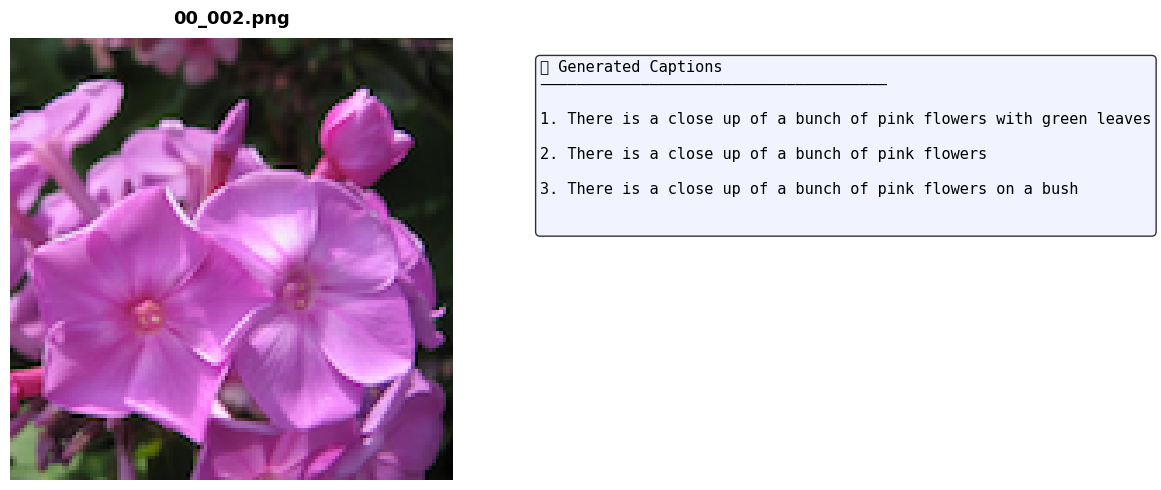


📝 Captions:
   1. There is a close up of a bunch of pink flowers with green leaves
   2. There is a close up of a bunch of pink flowers
   3. There is a close up of a bunch of pink flowers on a bush


In [7]:
print("📂 Select an image to upload...")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    image    = Image.open(filename).convert('RGB')
    print(f"\n✅ Uploaded: {filename}")
    print(f"   Size: {image.size[0]}x{image.size[1]} px")
    print("\n⏳ Generating captions...")
    captions = generate_caption(image, num_captions=3, num_beams=5)
    show_image_with_captions(image, captions, title=filename)
    print("\n📝 Captions:")
    for i, cap in enumerate(captions, 1):
        print(f"   {i}. {cap}")
else:
    print("⚠️  No file uploaded.")

🌐 Fetching image from URL...
✅ Loaded — Size: 1024x682 px
⏳ Generating captions...


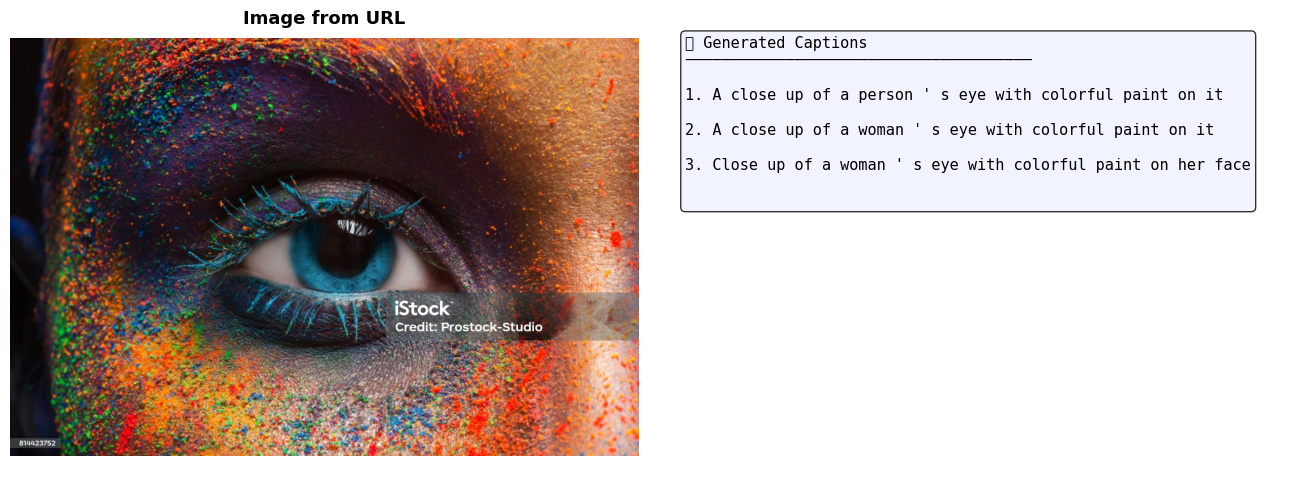


📝 Captions:
   1. A close up of a person ' s eye with colorful paint on it
   2. A close up of a woman ' s eye with colorful paint on it
   3. Close up of a woman ' s eye with colorful paint on her face


In [9]:
IMAGE_URL = "https://media.istockphoto.com/id/814423752/photo/eye-of-model-with-colorful-art-make-up-close-up.jpg?s=1024x1024&w=is&k=20&c=NQtm4v1Uzp2luv-6f3qORcq9pDtz2H56p8g9Xix8cY0="
# ────────────────────────────────────────────────────────────────

print("🌐 Fetching image from URL...")
response = requests.get(IMAGE_URL, timeout=10)
image    = Image.open(BytesIO(response.content)).convert('RGB')
print(f"✅ Loaded — Size: {image.size[0]}x{image.size[1]} px")
print("⏳ Generating captions...")

captions = generate_caption(image, num_captions=3, num_beams=5)
show_image_with_captions(image, captions, title="Image from URL")

print("\n📝 Captions:")
for i, cap in enumerate(captions, 1):
    print(f"   {i}. {cap}")


💬 Prompt: 'a photo of'
⏳ Generating prompted captions...


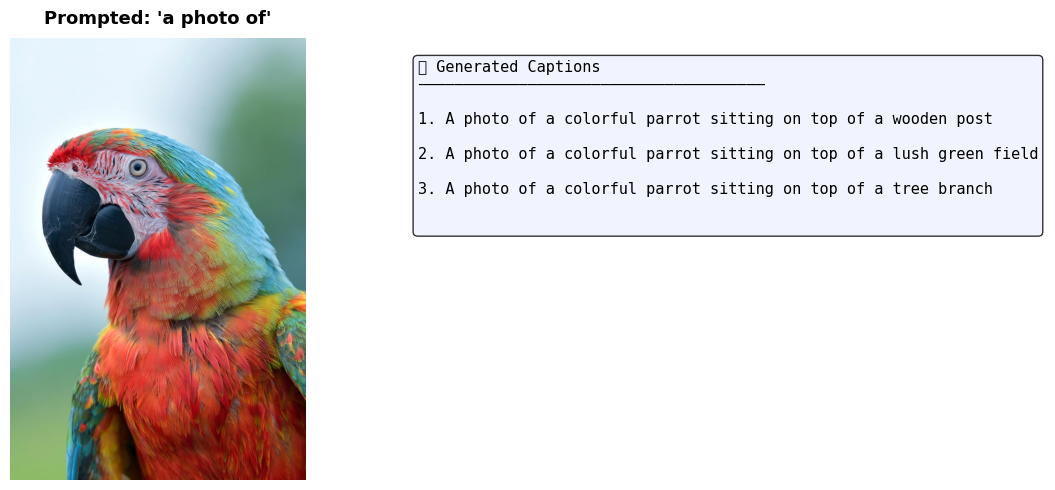


📝 Prompted Captions:
   1. A photo of a colorful parrot sitting on top of a wooden post
   2. A photo of a colorful parrot sitting on top of a lush green field
   3. A photo of a colorful parrot sitting on top of a tree branch


In [11]:
IMAGE_URL = "https://img.freepik.com/free-photo/closeup-scarlet-macaw-from-side-view-scarlet-macaw-closeup-head_488145-3540.jpg?semt=ais_hybrid&w=740&q=80"
PROMPT    = "a photo of"
# ────────────────────────────────────────────────────────────────

response = requests.get(IMAGE_URL, timeout=10)
image    = Image.open(BytesIO(response.content)).convert('RGB')

print(f"💬 Prompt: '{PROMPT}'")
print("⏳ Generating prompted captions...")

captions = generate_caption(image, prompt=PROMPT, num_captions=3, num_beams=5)
show_image_with_captions(image, captions, title=f"Prompted: '{PROMPT}'")

print("\n📝 Prompted Captions:")
for i, cap in enumerate(captions, 1):
    print(f"   {i}. {cap}")

In [12]:
import pandas as pd, time

# ── Add your image URLs here ─────────────────────────────────────
IMAGE_URLS = [
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSNubLmqdOK9pZWU-2IiD20cuSIdUUDi9-NvQ&s",
    "https://cdn.pixabay.com/photo/2017/07/24/19/57/tiger-2535888_640.jpg",
]
# ────────────────────────────────────────────────────────────────

results = []
print(f"⏳ Processing {len(IMAGE_URLS)} images...\n")

for idx, url in enumerate(IMAGE_URLS, 1):
    try:
        t0       = time.time()
        response = requests.get(url, timeout=10)
        image    = Image.open(BytesIO(response.content)).convert('RGB')
        captions = generate_caption(image, num_captions=1, num_beams=4)
        elapsed  = time.time() - t0
        results.append({'image': url.split('/')[-1], 'caption': captions[0], 'time_s': round(elapsed,2)})
        print(f'  [{idx}] ✅ {url.split("/")[-1]}')
        print(f'        → {captions[0]}')
        print(f'        ⏱  {elapsed:.2f}s\n')
    except Exception as e:
        print(f'  [{idx}] ❌ Failed: {e}')

df = pd.DataFrame(results)
df.to_csv("captions_output.csv", index=False)
print(df.to_string(index=False))
print("\n💾 Saved to captions_output.csv")


⏳ Processing 2 images...

  [1] ✅ images?q=tbn:ANd9GcSNubLmqdOK9pZWU-2IiD20cuSIdUUDi9-NvQ&s
        → There is a woman taking a picture with a camera in front of a tree
        ⏱  15.75s

  [2] ✅ tiger-2535888_640.jpg
        → There is a tiger that is swimming in the water
        ⏱  11.70s

                                                    image                                                            caption  time_s
images?q=tbn:ANd9GcSNubLmqdOK9pZWU-2IiD20cuSIdUUDi9-NvQ&s There is a woman taking a picture with a camera in front of a tree   15.75
                                    tiger-2535888_640.jpg                     There is a tiger that is swimming in the water   11.70

💾 Saved to captions_output.csv


In [14]:
!pip install nltk -q
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt', quiet=True)

# ── Your reference captions ──────────────────────────────────────
reference_captions = [
    "a dog sitting on a grassy field",
    "a cute brown dog is looking at the camera",
    "a dog outdoors in nature"
]
# ────────────────────────────────────────────────────────────────

IMAGE_URL = "https://img.freepik.com/free-photo/closeup-shot-beautiful-butterfly-with-interesting-textures-orange-petaled-flower_181624-7640.jpg?semt=ais_user_personalization&w=740&q=80"
response  = requests.get(IMAGE_URL, timeout=10)
image     = Image.open(BytesIO(response.content)).convert('RGB')
generated = generate_caption(image, num_captions=1, num_beams=5)[0].lower()

refs     = [ref.split() for ref in reference_captions]
hyp      = generated.split()
smoother = SmoothingFunction().method1

bleu1 = sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoother)
bleu2 = sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smoother)
bleu4 = sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoother)

print("📊 BLEU Score Evaluation")
print("=" * 40)
print(f"Generated : {generated}")
print(f"BLEU-1 : {bleu1:.4f}")
print(f"BLEU-2 : {bleu2:.4f}")
print(f"BLEU-4 : {bleu4:.4f}")

📊 BLEU Score Evaluation
Generated : there is a butterfly that is sitting on top of a flower
BLEU-1 : 0.4167
BLEU-2 : 0.1946
BLEU-4 : 0.0453
